# Forecasting Model with ARIMA

This is the second notebook of a series to present different forecasting models. We will be using the **ARIMA** model provided by **statsmodels** library. ARIMA stands for Auto Regression(AR) and Moving Average(MA)

One main difference between ARIMA and Exponential Smoothing model (first notebook) is that the ARIMA model requieres these three arguments:

1. **p** is the number of autoregressive terms
2. **d** is the number of nonseasonal differences
3. **q** is the number of lagged forecast errors

Other thing to keep in mind while using ARIMA model is that its main focus is on time series that are **stationary**, for data that does not change over the time that much and the data we have here is non stationary.
For learning pourpuses we will continue as is. It is also good to compare the different options we have in Machine Learning.

We will find this values for our dataset in the **Decomposing The Data Set** step.

The dataset is the **Alphabet Inc.** daily stock prices that can be downloaed from [Yahoo Finance](https://finance.yahoo.com/quote/GOOG/history?p=GOOG). Data ranged from Jan-2020 to Dec-2023.

The target colum is **Close** column. It represents the stock price at the end of the day.

Here are the steps we will follow in each notebook:

1. Data Preparation
2. Decomposing The Data Set
3. Traing The Model
4. Evaluate The Model

# Data Preparation

In [225]:
# Import usefull libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Deactivate warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

In [226]:
# Collect the dataset
df = pd.read_csv('GOOG.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,67.077499,68.406998,67.077499,68.368500,68.368500,28132000
1,2020-01-03,67.392998,68.625000,67.277199,68.032997,68.032997,23728000
2,2020-01-06,67.500000,69.824997,67.500000,69.710503,69.710503,34646000
3,2020-01-07,69.897003,70.149498,69.518997,69.667000,69.667000,30054000
4,2020-01-08,69.603996,70.579002,69.542000,70.216003,70.216003,30560000


In [227]:
# Check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1006 non-null   object 
 1   Open       1006 non-null   float64
 2   High       1006 non-null   float64
 3   Low        1006 non-null   float64
 4   Close      1006 non-null   float64
 5   Adj Close  1006 non-null   float64
 6   Volume     1006 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.1+ KB


In [228]:
# Use date column as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Remove duplicates based on index, keep first found
df = df[~df.index.duplicated(keep='first')]
df.asfreq('D')
df.sort_index(inplace=True)

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,67.077499,68.406998,67.077499,68.368500,68.368500,28132000
2020-01-03,67.392998,68.625000,67.277199,68.032997,68.032997,23728000
2020-01-06,67.500000,69.824997,67.500000,69.710503,69.710503,34646000
2020-01-07,69.897003,70.149498,69.518997,69.667000,69.667000,30054000
2020-01-08,69.603996,70.579002,69.542000,70.216003,70.216003,30560000


# Decomposing The Data Set

We will discover:

* Trends
* Seasonality
* Residuals

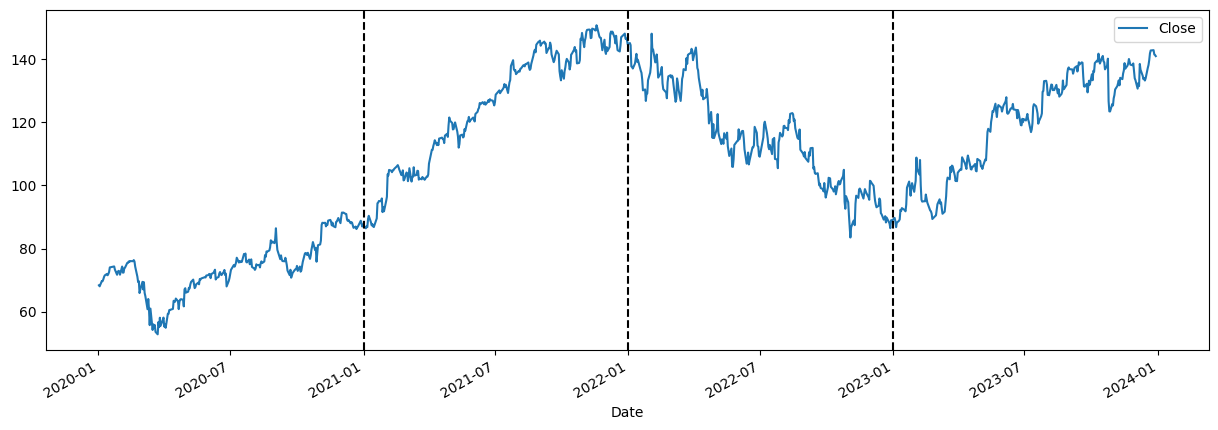

In [229]:
# Plot the data
vlines = ['2021-01-01', '2022-01-01', '2023-01-01']

df.plot(y='Close', figsize=(15,5))

for line in vlines:
  plt.axvline(x=line, color='black', linestyle='--')

plt.show()

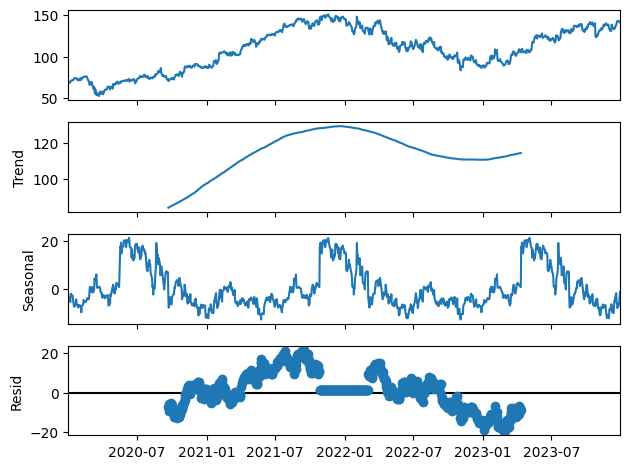

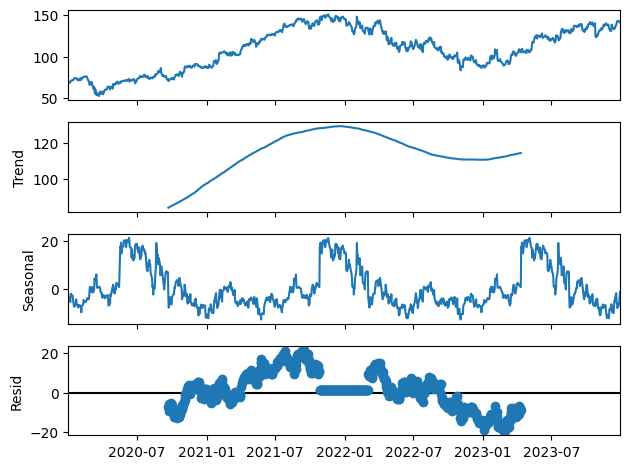

In [230]:
# Plot the decompose item
series = df[['Close']].copy()
decompose_result_mult = seasonal_decompose(series, model="additive", period=365)


decompose_result_mult.plot()

### Find if the series is non-stationary using Augmented Dickey-Fuller Test



In [231]:
# Call the adfuller() class
result = adfuller(df['Close'])

# Print the results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

# If p-value is more that 0.05 means that the data series is non-stationary
# otherwise it is stationary
for key, value in result[4].items():
  print('\t%s: %.2f' % (key, value))

ADF Statistic: -1.511345
p-value: 0.527892
Critical Values:
	1%: -3.44
	5%: -2.86
	10%: -2.57


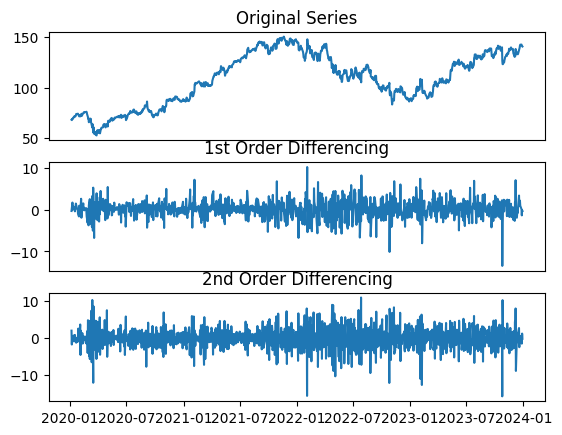

In [232]:
# We can plot the 1st and 2nd order differencing to see if the series become stationary

fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df['Close']); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df['Close'].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df['Close'].diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

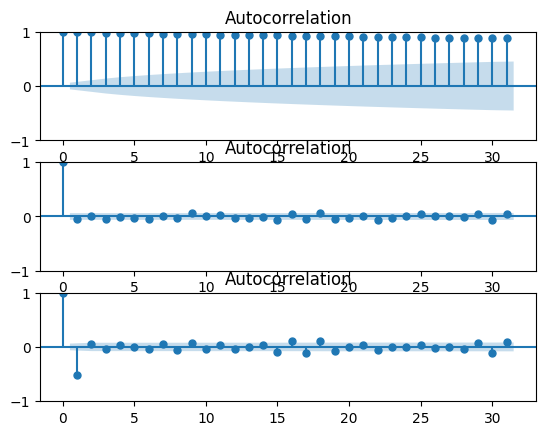

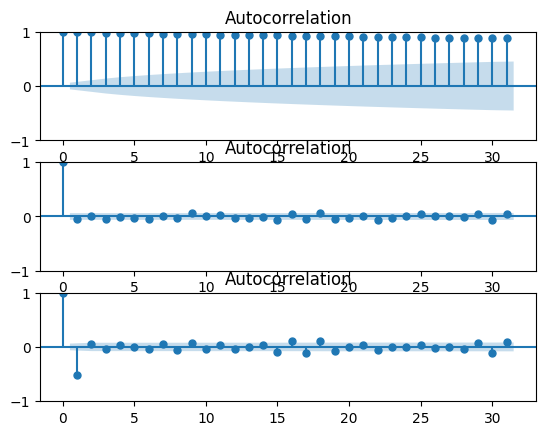

In [233]:
# as the dataset is non-stationary we need to identify the number of nonseasonal differences
# We can use the autocorrelation plot from statsmodels, apply two differences levels and compare if noise reduces

fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(df['Close'], ax=ax1)
plot_acf(df['Close'].diff().dropna(), ax=ax2)
plot_acf(df['Close'].diff().diff().dropna(), ax=ax3)

In the previous output we can see that we reduced the noise of the series by the first-order difference.

***d = 1***

In [234]:
d = 1

### Finding p - the number of autoregressive terms

We will use the partial autocorrelation function plot to draw and find the correlation between the series and its lags.

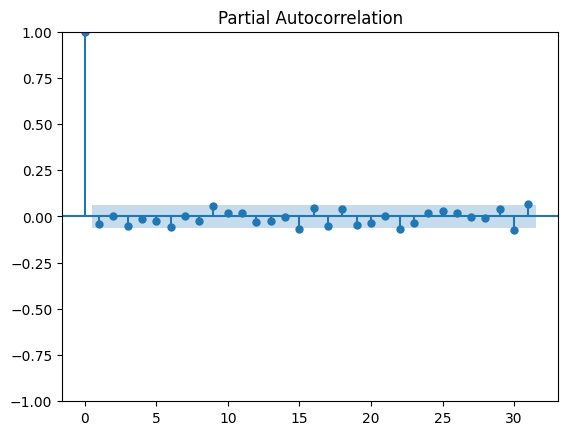

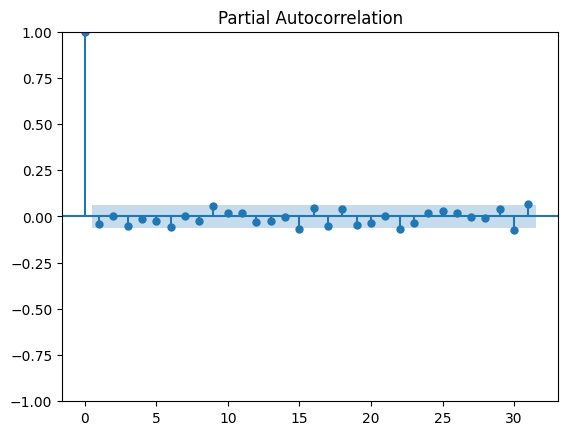

In [235]:
plot_pacf(df['Close'].diff().dropna())

As the first lag is way out of the limit (blue area):

***p = 1***

In [236]:
p = 1

### Finding q - the number of lagged forecast errors

We can use the ACF plot and depending on the lags that are out of the significance limit we can define **q**

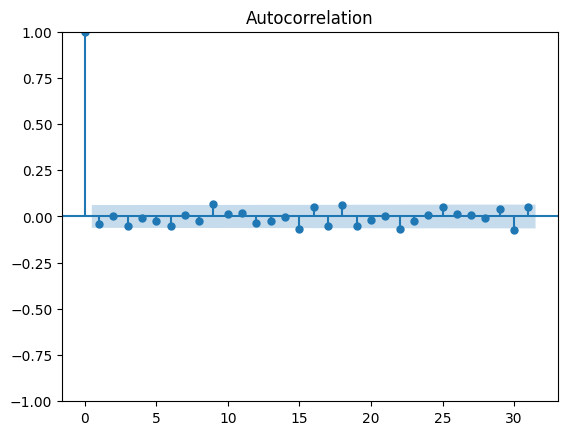

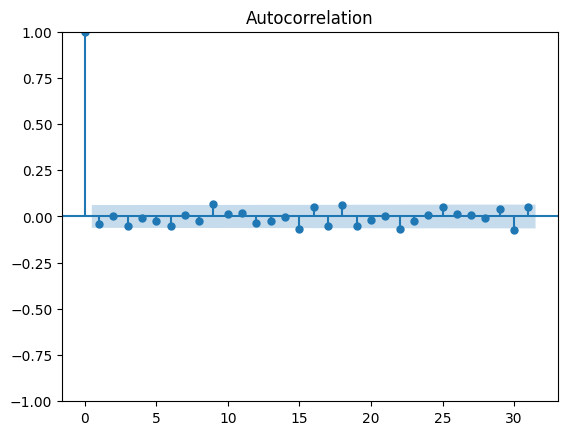

In [237]:
plot_acf(df['Close'].diff().dropna())

***q = 1***

In [238]:
q =1

# Traing The Model


In [239]:
future = pd.date_range('2024-01-01', '2025-01-01', freq='D')
len(future)

367

In [240]:
# Define the ARIMA model
# pass the found p,d,q
model = ARIMA(df['Close'], order=(p,d,q))
model_fit = model.fit()

# Evaluate The Model

In [241]:
# Forecast 180 days
preds = model_fit.predict(len(df['Close']), len(df['Close'])+180, typ='levels')
preds

1006    140.952803
1007    140.941121
1008    140.947104
1009    140.944040
1010    140.945609
           ...    
1182    140.945077
1183    140.945077
1184    140.945077
1185    140.945077
1186    140.945077
Name: predicted_mean, Length: 181, dtype: float64

In [242]:
# Concat forecast and fitted values
future = pd.date_range(df.index.max(), df.index.max() + pd.DateOffset(days=180), freq='D')

forecast = pd.DataFrame({'Date': future, 'pred': preds})

# Use date column as index
forecast['Date'] = pd.to_datetime(forecast['Date'])
forecast.set_index('Date', inplace=True)

forecast

,pred
Date,
2023-12-29,140.952803
2023-12-30,140.941121
2023-12-31,140.947104
2024-01-01,140.944040
2024-01-02,140.945609
...,...
2024-06-22,140.945077
2024-06-23,140.945077
2024-06-24,140.945077


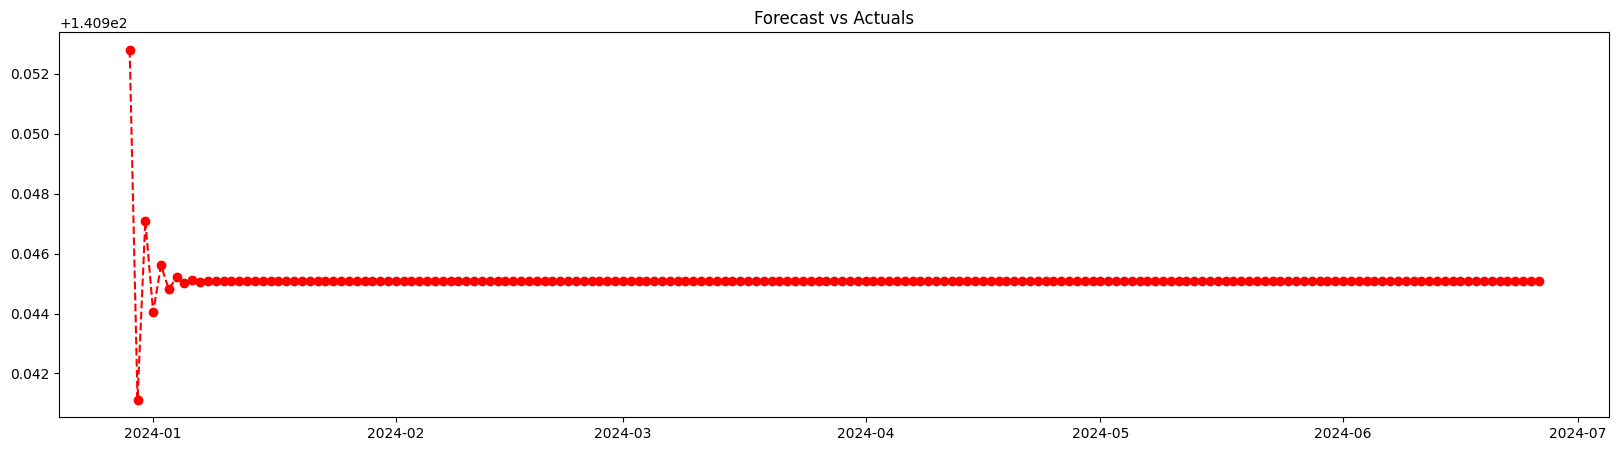

In [243]:
# Plot prediction values

plt.figure(figsize=(20,5))
plt.title('Forecast vs Actuals')
plt.plot(forecast['pred'], '--o', color='red')

plt.show()

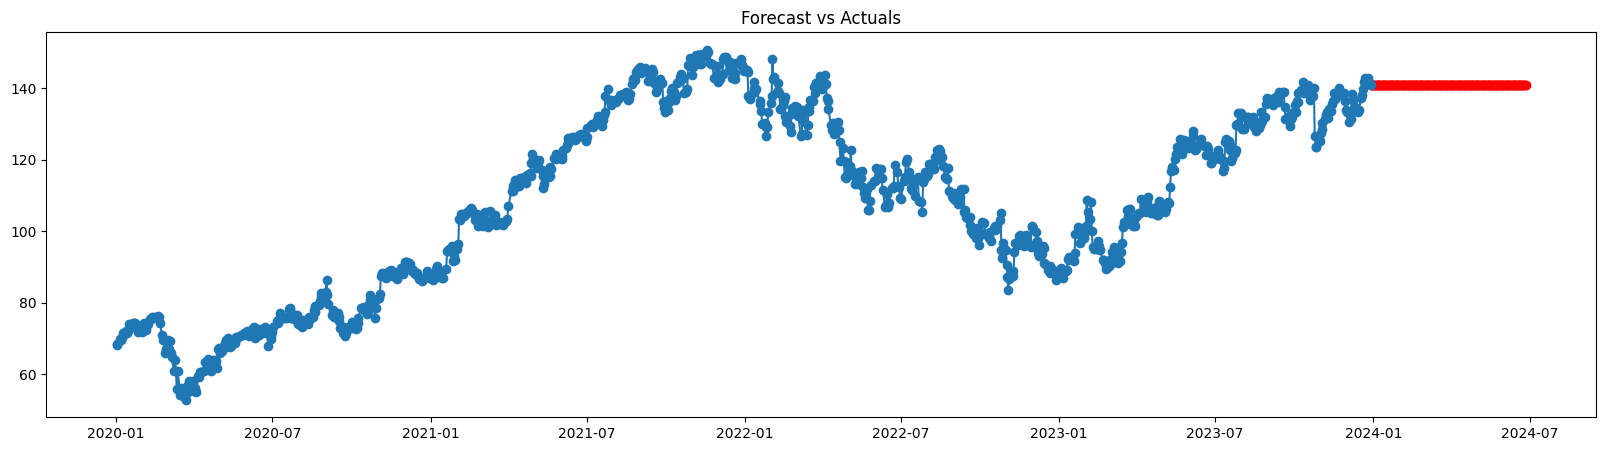

In [244]:
# Plot both values

plt.figure(figsize=(20,5))
plt.title('Forecast vs Actuals')
plt.plot(forecast['pred'], '--o', color='red')
plt.plot(df['Close'], '-o')

plt.show()

# Next Steps

* Use the improved mode ***SARIMAX*** (comming on the next notebook)
* Include measures in the **Evaluate the Model** section